In [1]:
import os
import re
import string
from collections import Counter
from collections import defaultdict
from datetime import datetime
from string import punctuation
from urllib.parse import urlparse

import networkx as nx
import nltk
import matplotlib
import pandas as pd
import seaborn as sns
import tldextract
from nltk.corpus import stopwords
from nltk.util import ngrams
from textblob import TextBlob

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.max_open_warning'] = 1000
matplotlib.rcParams['lines.linewidth'] = 1.0

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
def my_ngrams(tokens, rg):
    ngrms = []
    for i in range(rg[0], rg[1] + 1):
        ngrms_aux = [ngrm for ngrm in ngrams(tokens, i)]
        ngrms.extend(ngrms_aux)
    return ngrms

# Preparing data

## Selected keywords

In [4]:
original_keywords = ["Picard", "Kirk", "Sulu", "Uhura", "Spock", "McCoy", "Bones", "Scotty", "Chekhov", "Crusher", "Nurse Chapel", "Sarek", "Nero", "Khan", "Data", "Pike", "Star Trek", "Klingon", "Vulcan", "Romulan", "Star fleet", "Starship Enterprise", "Delta Vega", "Earth", "Orion", "Romulan Narada", "Stardate", "Transporter beam", "Beam me up,\? Scotty", "Kobayashi Maru", "Space,\? The Final Frontier", "Energize", "Vulcan Salute", "Prime Directive", "Live long and prosper", "LLAP", "I'm a doctor,\? not a", "KHAAA\+N", "When you eliminate the impossible,\? whatever remains,\? however improbable,\? must be the truth", "Without followers,\? evil cannot spread", "The needs of the many outweigh the needs of the few", "Highly illogical", "to boldly go where no man has gone before", "I'm giving her all she's got,\? Captain", "Nuclear wessels", "Set phasers to stun", "Resistance is futile", "I have been and always shall be your friend"]

In [5]:
print(original_keywords)

['Picard', 'Kirk', 'Sulu', 'Uhura', 'Spock', 'McCoy', 'Bones', 'Scotty', 'Chekhov', 'Crusher', 'Nurse Chapel', 'Sarek', 'Nero', 'Khan', 'Data', 'Pike', 'Star Trek', 'Klingon', 'Vulcan', 'Romulan', 'Star fleet', 'Starship Enterprise', 'Delta Vega', 'Earth', 'Orion', 'Romulan Narada', 'Stardate', 'Transporter beam', 'Beam me up,\\? Scotty', 'Kobayashi Maru', 'Space,\\? The Final Frontier', 'Energize', 'Vulcan Salute', 'Prime Directive', 'Live long and prosper', 'LLAP', "I'm a doctor,\\? not a", 'KHAAA\\+N', 'When you eliminate the impossible,\\? whatever remains,\\? however improbable,\\? must be the truth', 'Without followers,\\? evil cannot spread', 'The needs of the many outweigh the needs of the few', 'Highly illogical', 'to boldly go where no man has gone before', "I'm giving her all she's got,\\? Captain", 'Nuclear wessels', 'Set phasers to stun', 'Resistance is futile', 'I have been and always shall be your friend']


In [6]:
ambiguous_keywords = [
    'Bones',
    'Khan',
    'Data',
    'Earth',
    'Energize',
]

In [7]:
keywords = list(set(original_keywords).difference(ambiguous_keywords))
keywords = [w.replace('\\', '').lower() for w in keywords]
keywords.sort()

In [8]:
print(keywords)

['beam me up,? scotty', 'chekhov', 'crusher', 'delta vega', 'highly illogical', 'i have been and always shall be your friend', "i'm a doctor,? not a", "i'm giving her all she's got,? captain", 'khaaa+n', 'kirk', 'klingon', 'kobayashi maru', 'live long and prosper', 'llap', 'mccoy', 'nero', 'nuclear wessels', 'nurse chapel', 'orion', 'picard', 'pike', 'prime directive', 'resistance is futile', 'romulan', 'romulan narada', 'sarek', 'scotty', 'set phasers to stun', 'space,? the final frontier', 'spock', 'star fleet', 'star trek', 'stardate', 'starship enterprise', 'sulu', 'the needs of the many outweigh the needs of the few', 'to boldly go where no man has gone before', 'transporter beam', 'uhura', 'vulcan', 'vulcan salute', 'when you eliminate the impossible,? whatever remains,? however improbable,? must be the truth', 'without followers,? evil cannot spread']


## Comments

In [9]:
%%time

dtypes = {
    'author': str,
    'body': str,
    'controversiality': int,
    'created_utc': pd.tslib.Timestamp,
    'distinguished': str,
    'downs': str,
    'gilded': str,
    'id': str,
    'name': str,
    'parent_id': str,
    'score': int,
    'subreddit': str,
    'ups': str,
    'month': pd.tslib.Timestamp,
    'year': pd.tslib.Timestamp,
}

reddit_df = pd.read_csv('reddit.csv', header=0, dtype=dtypes, parse_dates=['created_utc', 'month', 'year'])
reddit_df = reddit_df.fillna(0)

CPU times: user 30.4 s, sys: 1.14 s, total: 31.6 s
Wall time: 31.6 s


In [10]:
len(reddit_df)

2669814

In [11]:
reddit_df.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
0,gschizas,same in greek. my personal peeve: quite a lot ...,0,2007-10-15 15:22:33,0,0.0,0,c029c79,t1_c029c79,t1_c029brz,13,programming,13,2007-10-01,2007-01-01
1,[deleted],&gt;they also decided to rig a thermal barrier...,0,2007-10-16 05:11:09,0,0.0,0,c029g6h,t1_c029g6h,t3_5ye94,2,programming,2,2007-10-01,2007-01-01
2,johnmudd,&gt; by the time a child born today graduates ...,0,2007-10-16 07:00:36,0,0.0,0,c029gfc,t1_c029gfc,t3_5ye9w,1,science,1,2007-10-01,2007-01-01
3,feliniti,nero 8 - bloated waste of money. unless you ha...,0,2007-10-16 07:10:27,0,0.0,0,c029gge,t1_c029gge,t3_5yej4,1,reddit.com,1,2007-10-01,2007-01-01
4,masklinn,&gt; i wonder what happens if you started clea...,0,2007-10-16 11:27:15,0,0.0,0,c029hiy,t1_c029hiy,t1_c029h3y,3,reddit.com,3,2007-10-01,2007-01-01


# Analyzing data

## Links

In [12]:
%%time

url_regex = r'https?://[^\s]+'
link_dict = defaultdict(int)
link_errors = set()
body_errors = set()

for x in reddit_df['body']:
    try:
        urls =  re.findall(url_regex, x)
        for url in urls:
            url = url.strip(punctuation).replace('\\', '')
            try:
                parse = urlparse(url)
                link_dict[parse.geturl()] += 1
            except:
                link_errors.add(url)
    except:
        body_errors.add(x)

CPU times: user 22.5 s, sys: 47.5 ms, total: 22.5 s
Wall time: 22.5 s


In [13]:
len(link_dict)

522856

In [14]:
len(link_errors)

23

In [15]:
len(body_errors)

1

In [16]:
link_counter = Counter(link_dict)

In [17]:
link_counter.most_common()

[('http://www.reddit.com/r/qkme_transcriber/comments/o426k/faq_for_the_qkme_transcriber_bot',
  6764),
 ('http://www.reddit.com/r/self/comments/vxeak/hello_i_am_a_bot_who_posts_transcriptions_of',
  6085),
 ('http://www.reddit.com/r/qkme_transcriber', 3153),
 ('http://pcpartpicker.com/part/seagate-internal-hard-drive-st1000dm003',
  2739),
 ('http://www.reddit.com/r/internetama/comments/12gog9/i_am_the_creator_of_qkme_transcriber_a_definitely',
  2627),
 ('http://imgur.com/6trtl', 2289),
 ('http://pcpartpicker.com/part/team-memory-tlyd38g1600hc9dc01', 2242),
 ('http://pcpartpicker.com/part/western-digital-internal-hard-drive-wd10ezex',
  2093),
 ('http://pcpartpicker.com/part/team-memory-tld38g1600hc9dc01', 2043),
 ('http://www.reddit.com/r/startrek/comments/1jfazc/meta_test_run_for_the_month_of_august_all_image',
  1974),
 ('http://www.trekcore.com/audio/computer/processing.mp3', 1970),
 ('http://www.trekcore.com/audio/computer/voice/inputalgorithmnotaccepted_ep.mp3',
  1969),
 ('http

## Netlocs

In [18]:
%%time

netloc_dict = defaultdict(int)
netloc_errors = set()

for url in link_dict:
    try:
        parse = urlparse(url)
        netloc_dict[parse.netloc] += link_dict[url]
    except:
        netloc_errors.add(url)

CPU times: user 5.57 s, sys: 28 µs, total: 5.57 s
Wall time: 5.57 s


In [19]:
len(netloc_dict)

48890

In [20]:
len(netloc_errors)

0

In [21]:
netloc_counter = Counter(netloc_dict)

In [22]:
netloc_counter.most_common()

[('www.reddit.com', 138473),
 ('pcpartpicker.com', 92951),
 ('www.youtube.com', 73840),
 ('en.wikipedia.org', 65855),
 ('imgur.com', 65226),
 ('i.imgur.com', 30148),
 ('boardgamegeek.com', 29984),
 ('youtu.be', 22278),
 ('gatherer.wizards.com', 16812),
 ('reddit.com', 16338),
 ('twitter.com', 11651),
 ('youtube.com', 11635),
 ('www.imdb.com', 7854),
 ('www.np.reddit.com', 7551),
 ('en.memory-alpha.org', 7402),
 ('store.steampowered.com', 7181),
 ('translate.google.com', 7174),
 ('www.amazon.com', 7036),
 ('xn--e1agvr0b.xn--j1aef.xn--p1ai', 6324),
 ('i.qkme.me', 6270),
 ('github.com', 5057),
 ('steamcommunity.com', 4460),
 ('magiccards.info', 4066),
 ('www.trekcore.com', 3996),
 ('np.reddit.com', 3956),
 ('xn--80adiba3abddchue7e4b.xn--p1ai', 3846),
 ('www.twitch.tv', 3770),
 ('investigationbooks.ru', 3084),
 ('www.telescope.com', 2942),
 ('soundcloud.com', 2803),
 ('xn--b1actsqfc5b.xn--j1aef.xn--p1ai', 2778),
 ('www.google.com', 2685),
 ('tvtropes.org', 2445),
 ('ca.pcpartpicker.com', 2

## Domain web

In [23]:
%%time

domain_dict = defaultdict(int)
domain_errors = set()

for url in netloc_dict:
    try:
        parse = tldextract.extract(url)
        domain_dict[parse.domain] += netloc_dict[url]
    except:
        domain_errors.add(url)

CPU times: user 1.09 s, sys: 7.93 ms, total: 1.09 s
Wall time: 1.09 s


In [24]:
len(domain_dict)

35163

In [25]:
len(domain_errors)

0

In [26]:
domain_dict['youtube'] += domain_dict['youtu']
del(domain_dict['youtu'])

In [27]:
domain_counter = Counter(domain_dict)

In [28]:
domain_counter.most_common()

[('reddit', 167243),
 ('youtube', 108399),
 ('pcpartpicker', 98888),
 ('imgur', 95875),
 ('wikipedia', 67185),
 ('boardgamegeek', 30271),
 ('wizards', 16908),
 ('google', 14638),
 ('twitter', 12042),
 ('xn--j1aef', 9906),
 ('memory-alpha', 8509),
 ('imdb', 8044),
 ('amazon', 7881),
 ('wikia', 7412),
 ('steampowered', 7405),
 ('qkme', 6357),
 ('github', 5611),
 ('steamcommunity', 4475),
 ('trekcore', 4398),
 ('magiccards', 4066),
 ('xn--80adiba3abddchue7e4b', 3846),
 ('twitch', 3816),
 ('tumblr', 3282),
 ('blogspot', 3273),
 ('investigationbooks', 3084),
 ('wordpress', 2983),
 ('telescope', 2949),
 ('soundcloud', 2843),
 ('wikimedia', 2532),
 ('tvtropes', 2483),
 ('nocookie', 2413),
 ('deviantart', 2028),
 ('narffl', 1948),
 ('nfl', 1884),
 ('gamepedia', 1819),
 ('shortwww', 1744),
 ('xn--80aaqbi4ajie6m', 1692),
 ('radd', 1687),
 ('redd', 1519),
 ('archive', 1502),
 ('mtgprice', 1496),
 ('facebook', 1474),
 ('tvrage', 1425),
 ('shouters', 1308),
 ('memedad', 1284),
 ('photobucket', 1237

# Visualizing data

## Bar chart

In [29]:
viz = domain_counter.most_common(200)

In [30]:
viz[:5]

[('reddit', 167243),
 ('youtube', 108399),
 ('pcpartpicker', 98888),
 ('imgur', 95875),
 ('wikipedia', 67185)]

In [31]:
viz_keys = [a for a, b in viz[:20]]
viz_data = [b for a, b in viz[:20]]

In [32]:
domain_sr = pd.Series(viz_data, index=viz_keys)

In [33]:
domain_sr.head()

reddit          167243
youtube         108399
pcpartpicker     98888
imgur            95875
wikipedia        67185
dtype: int64

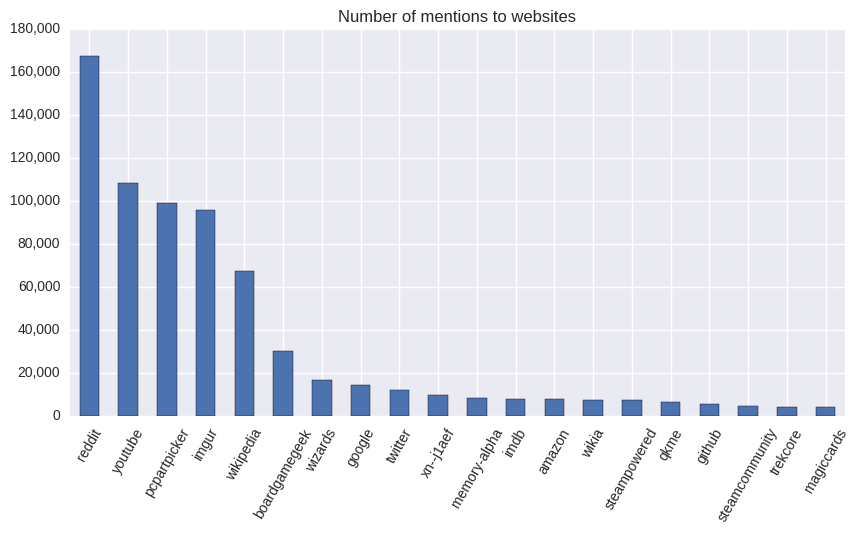

In [34]:
ax = domain_sr.plot(
    figsize=(10,5),
    xticks=range(len(domain_sr.index)),
    rot=60,
    title='Number of mentions to websites',
    kind='bar',
)
ax.set_xticklabels(domain_sr.index);
formatter = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
ax.get_yaxis().set_major_formatter(formatter)

## Network

In [35]:
domain_graph = nx.Graph()

In [36]:
for a, b in viz:
    domain_graph.add_node(a, weight=b)

In [37]:
nx.write_gexf(domain_graph, 'domain_graph.gexf')